In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
from pathlib import Path

ZIP_PATH = Path("/content/drive/MyDrive/Colab_dataset/archive(9).zip")
EXTRACT_DIR = Path("dataset_extracted")

with zipfile.ZipFile(ZIP_PATH, 'r') as zf:
    zf.extractall(EXTRACT_DIR)

print("Dataset extracted to:", EXTRACT_DIR.resolve())


Dataset extracted to: /content/dataset_extracted


In [3]:
import os
import cv2
import shutil
import random
from pathlib import Path

# Path jahan tumhara training data hai
train_dir = Path("dataset_extracted/train")

# Naya validation folder ka path
val_dir = Path("dataset_extracted/val")
val_dir.mkdir(exist_ok=True)

# Har class ke liye 10% images val folder me move karte hain
for class_folder in train_dir.iterdir():
    if class_folder.is_dir():
        val_class_dir = val_dir / class_folder.name
        val_class_dir.mkdir(parents=True, exist_ok=True)

        # Folder ke andar sab images list karo
        images = list(class_folder.glob("*.*"))
        random.shuffle(images)
        val_count = int(0.1 * len(images))  # 10% split
        val_images = images[:val_count]

        # Images move kar do validation folder me
        for img_path in val_images:
            shutil.move(str(img_path), str(val_class_dir / img_path.name))

print("Validation  split created successfully!")


Validation  split created successfully!


In [4]:
for folder in os.listdir("dataset_extracted/test"):
    path = os.path.join("dataset_extracted/test", folder)
    print(f"{folder}: {len(os.listdir(path))} images")

debris: 100 images
Damaged_building: 100 images
Non-damaged_building: 200 images
Non-damaged_highway: 100 images
Damaged_highway: 100 images


In [5]:
for folder in os.listdir("dataset_extracted/train"):
    path = os.path.join("dataset_extracted/train", folder)
    print(f"{folder}: {len(os.listdir(path))} images")

debris: 372 images
Non-damaged_building: 1495 images
Non-damaged_highway: 478 images
Damaged_highway: 648 images
damaged_buildings: 404 images


In [6]:
for folder in os.listdir("dataset_extracted/val"):
    path = os.path.join("dataset_extracted/val", folder)
    print(f"{folder}: {len(os.listdir(path))} images")


debris: 41 images
Non-damaged_building: 166 images
Non-damaged_highway: 53 images
Damaged_highway: 72 images
damaged_buildings: 44 images


In [7]:
# Imports
import os
from pathlib import Path
import json
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix
import itertools

# To show progress Bar
from tqdm import tqdm

In [8]:
import matplotlib.pyplot as plt

In [9]:
# Paths and hyperparameters

BASE_DIR = Path("dataset_extracted")   # your extracted dataset folder
TRAIN_DIR = BASE_DIR / "train"
VAL_DIR   = BASE_DIR / "val"
TEST_DIR  = BASE_DIR / "test"

IMG_SIZE = (224, 224)     # MobileNetV2 recommended size
BATCH_SIZE = 32
EPOCHS = 20
MODEL_SAVE_PATH = "road_damage_mobilenetv2.h5"
BEST_MODEL_PATH = "best_model.h5"
RANDOM_SEED = 42

tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)


In [10]:
# Store the input images folders
train_dir = 'dataset_extracted/train'      # this is train images folder
test_dir = 'dataset_extracted/test'        # this is test images folder

In [11]:
#For stored resized images

output_train_dir = 'Processed_Train'
output_test_dir = 'Processed_Test'

In [12]:
def is_blurry_or_low_res(image_path, blur_threshold=100, min_dim=50):
    """
    Checks if an image is blurry or low resolution.

    Args:
        image_path (str): The path to the image file.
        blur_threshold (int): The threshold for blur detection (lower means more blurry).
        min_dim (int): The minimum dimension (width or height) for an image to be considered not low resolution.

    Returns:
        bool: True if the image is blurry or low resolution, False otherwise.
    """
    img = cv2.imread(image_path)
    if img is None:
        return True  # Consider unreadable images as irrelevant

    # Check for low resolution
    if img.shape[0] < min_dim or img.shape[1] < min_dim:
        return True

    # Convert to grayscale for blur detection
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Calculate the variance of the Laplacian
    laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()

    # Check for blurriness
    if laplacian_var < blur_threshold:
        return True

    return False

def clean_dataset(input_folder, output_folder_cleaned, blur_threshold=100, min_dim=50):
    """
    Cleans a dataset by removing blurry, low-resolution, or irrelevant images.

    Args:
        input_folder (str): The path to the input dataset folder.
        output_folder_cleaned (str): The path to the output folder for cleaned images.
        blur_threshold (int): The threshold for blur detection.
        min_dim (int): The minimum dimension for an image.
    """
    os.makedirs(output_folder_cleaned, exist_ok=True)

    for category in os.listdir(input_folder):
        category_path = os.path.join(input_folder, category)
        cleaned_category_path = os.path.join(output_folder_cleaned, category)
        os.makedirs(cleaned_category_path, exist_ok=True)

        print(f"\n Cleaning Category: {category}")
        for file_name in tqdm(os.listdir(category_path)):
            file_path = os.path.join(category_path, file_name)
            if not is_blurry_or_low_res(file_path, blur_threshold, min_dim):
                # Copy the image to the cleaned folder if it's not blurry or low-res
                shutil.copy(file_path, cleaned_category_path)

    print("\nDataset cleaning complete.")

# Example usage:
# clean_dataset('dataset_extracted/train', 'dataset_extracted/train_cleaned')
# clean_dataset('dataset_extracted/test', 'dataset_extracted/test_cleaned')

In [13]:
# Function for resize and normalize image and clean
def preprocess_images(input_folder, output_folder, target_size=(224, 224), blur_threshold=100, min_dim=50):
    for category in os.listdir(input_folder):                 # for each class and folder
        category_path = os.path.join(input_folder, category)
        save_path = os.path.join(output_folder, category)

        os.makedirs(save_path, exist_ok=True)                 # Create the same class folder in the output

        print(f"\n Processing Category: {category}")
        for file_name in tqdm(os.listdir(category_path)):
            file_path = os.path.join(category_path, file_name)
            try:
                # Check if the image is blurry or low resolution
                if is_blurry_or_low_res(file_path, blur_threshold, min_dim):
                    print(f"Skipping blurry or low-res image: {file_name}")
                    continue

                # read image
                img = cv2.imread(file_path)
                if img is None:
                    print(f"Skipping unreadable image: {file_name}")
                    continue  # If the image is corrupted, then skip it.

                # resize image
                img_resized = cv2.resize(img, target_size)

                # normalize (0-1 range)
                img_normalized = img_resized / 255.0

                # save processed image
                save_file = os.path.join(save_path, file_name)
                cv2.imwrite(save_file, (img_normalized * 255))  # Convert back to 0-255 before saving

            except Exception as e:
                print(f"Error in {file_name}: {e}")

In [14]:
# Function call for both Train & Test data
preprocess_images(train_dir, output_train_dir)
preprocess_images(test_dir, output_test_dir)

print("All images resized and normalized successfully!")



 Processing Category: debris


 24%|██▍       | 89/372 [00:00<00:02, 136.07it/s]

Skipping blurry or low-res image: 1 (424).JPG
Skipping blurry or low-res image: 1 (413).JPG


 58%|█████▊    | 214/372 [00:01<00:01, 144.37it/s]

Skipping blurry or low-res image: 1 (295).JPG


100%|██████████| 372/372 [00:02<00:00, 154.17it/s]



 Processing Category: Non-damaged_building


  3%|▎         | 44/1495 [00:00<00:03, 432.13it/s]

Skipping blurry or low-res image: 4 (459).jpeg
Skipping blurry or low-res image: 4 (394).jpeg
Skipping blurry or low-res image: 4 (456).jpeg


  6%|▌         | 90/1495 [00:00<00:03, 445.48it/s]

Skipping blurry or low-res image: 4 (419).jpeg


 12%|█▏        | 180/1495 [00:00<00:02, 443.86it/s]

Skipping blurry or low-res image: 4 (158).jpeg
Skipping blurry or low-res image: 4 (307).jpeg


 15%|█▌        | 225/1495 [00:00<00:02, 433.25it/s]

Skipping blurry or low-res image: 4 (311).jpeg


 18%|█▊        | 271/1495 [00:00<00:02, 442.11it/s]

Skipping blurry or low-res image: 4 (128).jpeg
Skipping blurry or low-res image: 4 (288).jpeg
Skipping blurry or low-res image: 4 (210).jpeg
Skipping blurry or low-res image: 4 (203).jpeg


 27%|██▋       | 404/1495 [00:00<00:02, 425.51it/s]

Skipping blurry or low-res image: 4 (450).jpeg
Skipping blurry or low-res image: 4 (259).jpeg
Skipping blurry or low-res image: 4 (512).jpeg
Skipping blurry or low-res image: 4 (513).jpeg
Skipping blurry or low-res image: 4 (422).jpeg
Skipping blurry or low-res image: 4 (354).jpeg
Skipping blurry or low-res image: 4 (257).jpeg


 33%|███▎      | 498/1495 [00:01<00:02, 443.00it/s]

Skipping blurry or low-res image: 4 (402).jpeg
Skipping blurry or low-res image: 4 (460).jpeg
Skipping blurry or low-res image: 4 (230).jpeg


 39%|███▉      | 588/1495 [00:01<00:02, 440.13it/s]

Skipping blurry or low-res image: 4 (398).jpeg
Skipping blurry or low-res image: 4 (199).jpeg
Skipping blurry or low-res image: 4 (282).jpeg
Skipping blurry or low-res image: 4 (455).jpeg
Skipping blurry or low-res image: 4 (434).jpeg


 51%|█████▏    | 768/1495 [00:01<00:01, 441.56it/s]

Skipping blurry or low-res image: 4 (388).jpeg
Skipping blurry or low-res image: 4 (517).jpeg
Skipping blurry or low-res image: 4 (497).jpeg


 57%|█████▋    | 857/1495 [00:01<00:01, 430.57it/s]

Skipping blurry or low-res image: 4 (491).jpeg
Skipping blurry or low-res image: 4 (454).jpeg
Skipping blurry or low-res image: 4 (395).jpeg
Skipping blurry or low-res image: 4 (355).jpeg
Skipping blurry or low-res image: desktop.ini


 63%|██████▎   | 946/1495 [00:02<00:01, 429.31it/s]

Skipping blurry or low-res image: 4 (309).jpeg
Skipping blurry or low-res image: 4 (510).jpeg
Skipping blurry or low-res image: 4 (400).jpeg


 69%|██████▉   | 1036/1495 [00:02<00:01, 436.72it/s]

Skipping blurry or low-res image: 4 (399).jpeg
Skipping blurry or low-res image: 4 (431).jpeg


 78%|███████▊  | 1173/1495 [00:02<00:00, 446.07it/s]

Skipping blurry or low-res image: 4 (445).jpeg
Skipping blurry or low-res image: 4 (239).jpeg
Skipping blurry or low-res image: 4 (274).jpeg


 84%|████████▍ | 1259/1495 [00:02<00:00, 348.98it/s]

Skipping blurry or low-res image: 4 (514).jpeg
Skipping blurry or low-res image: 4 (508).jpeg
Skipping blurry or low-res image: 4 (468).jpeg
Skipping blurry or low-res image: 4 (424).jpeg
Skipping blurry or low-res image: 4 (530).jpeg


 91%|█████████ | 1362/1495 [00:03<00:00, 298.68it/s]

Skipping blurry or low-res image: okuu.m
Skipping blurry or low-res image: 4 (141).jpeg


 95%|█████████▌| 1424/1495 [00:03<00:00, 295.02it/s]

Skipping blurry or low-res image: 4 (401).jpeg
Skipping blurry or low-res image: 4 (270).jpeg
Skipping blurry or low-res image: 4 (511).jpeg
Skipping blurry or low-res image: 4 (124).jpeg


100%|██████████| 1495/1495 [00:03<00:00, 391.98it/s]


Skipping blurry or low-res image: 4 (129).jpeg

 Processing Category: Non-damaged_highway


 31%|███▏      | 150/478 [00:00<00:00, 392.99it/s]

Skipping blurry or low-res image: 5 (1011).JPG
Skipping blurry or low-res image: 5 (1002).JPG


 51%|█████     | 243/478 [00:00<00:00, 431.49it/s]

Skipping blurry or low-res image: 5 (695).jpg
Skipping blurry or low-res image: 5 (1013).JPG
Skipping blurry or low-res image: 5 (1004).JPG
Skipping blurry or low-res image: 5 (1136).JPG
Skipping blurry or low-res image: 5 (999).JPG
Skipping blurry or low-res image: 5 (1003).JPG
Skipping blurry or low-res image: 5 (1040).JPG
Skipping blurry or low-res image: 5 (1047).JPG


 89%|████████▊ | 424/478 [00:01<00:00, 444.70it/s]

Skipping blurry or low-res image: 5 (956).JPG
Skipping blurry or low-res image: 5 (1099).JPG
Skipping blurry or low-res image: okuu.m


100%|██████████| 478/478 [00:01<00:00, 417.31it/s]



 Processing Category: Damaged_highway


  6%|▌         | 36/648 [00:00<00:01, 349.32it/s]

Skipping blurry or low-res image: 3 (145).JPG
Skipping blurry or low-res image: 3 (156).JPG


 19%|█▉        | 122/648 [00:00<00:01, 406.08it/s]

Skipping blurry or low-res image: 3 (137).JPG


 25%|██▌       | 164/648 [00:00<00:01, 411.40it/s]

Skipping blurry or low-res image: 3 (153).JPG


 97%|█████████▋| 631/648 [00:01<00:00, 416.31it/s]

Skipping blurry or low-res image: 3 (146).JPG
Skipping blurry or low-res image: okuu.m
Skipping blurry or low-res image: 3 (152).JPG


100%|██████████| 648/648 [00:01<00:00, 409.40it/s]



 Processing Category: damaged_buildings


  2%|▏         | 8/404 [00:00<00:05, 76.50it/s]

Skipping blurry or low-res image: 2 (70).jpeg
Skipping blurry or low-res image: 2 (14).jpeg
Skipping blurry or low-res image: 2 (380).jpeg
Skipping blurry or low-res image: 2 (325).jpeg
Skipping blurry or low-res image: 2 (80).jpeg
Skipping blurry or low-res image: 2 (56).jpeg
Skipping blurry or low-res image: 2 (27).jpeg


  4%|▍         | 16/404 [00:00<00:05, 75.97it/s]

Skipping blurry or low-res image: 2 (326).jpeg


  6%|▌         | 24/404 [00:00<00:05, 73.92it/s]

Skipping blurry or low-res image: 2 (398).jpeg
Skipping blurry or low-res image: 2 (342).jpeg
Skipping blurry or low-res image: 2 (46).jpeg
Skipping blurry or low-res image: 2 (42).jpeg
Skipping blurry or low-res image: 2 (336).jpeg
Skipping blurry or low-res image: 2 (411).jpeg
Skipping blurry or low-res image: 2 (2).jpg


 10%|▉         | 40/404 [00:00<00:05, 71.41it/s]

Skipping blurry or low-res image: 2 (270).jpeg
Skipping blurry or low-res image: 2 (322).jpeg
Skipping blurry or low-res image: 2 (385).jpeg
Skipping blurry or low-res image: 2 (10).jpeg
Skipping blurry or low-res image: 2 (178).jpeg
Skipping blurry or low-res image: 2 (432).jpeg
Skipping blurry or low-res image: 2 (340).jpeg
Skipping blurry or low-res image: 2 (168).jpeg


 15%|█▌        | 61/404 [00:00<00:03, 87.58it/s]

Skipping blurry or low-res image: 2 (76).jpeg
Skipping blurry or low-res image: 2 (349).jpeg
Skipping blurry or low-res image: 2 (144).jpeg
Skipping blurry or low-res image: 2 (257).jpeg
Skipping blurry or low-res image: 2 (202).jpeg
Skipping blurry or low-res image: 2 (423).jpeg
Skipping blurry or low-res image: 2 (238).jpeg


 17%|█▋        | 70/404 [00:00<00:03, 84.76it/s]

Skipping blurry or low-res image: 2 (273).jpeg


 20%|█▉        | 79/404 [00:01<00:04, 77.32it/s]

Skipping blurry or low-res image: 2 (68).jpeg
Skipping blurry or low-res image: 2 (171).jpeg
Skipping blurry or low-res image: 2 (12).jpeg
Skipping blurry or low-res image: 2 (4).jpg
Skipping blurry or low-res image: 2 (151).jpeg
Skipping blurry or low-res image: 2 (234).jpeg


 22%|██▏       | 89/404 [00:01<00:03, 81.82it/s]

Skipping blurry or low-res image: 2 (412).jpeg
Skipping blurry or low-res image: 2 (265).jpeg
Skipping blurry or low-res image: 2 (213).jpeg
Skipping blurry or low-res image: 2 (241).jpeg
Skipping blurry or low-res image: 2 (181).jpeg


 25%|██▌       | 102/404 [00:01<00:03, 92.05it/s]

Skipping blurry or low-res image: 2 (200).jpeg
Skipping blurry or low-res image: 2 (5).jpeg
Skipping blurry or low-res image: 2 (299).jpeg
Skipping blurry or low-res image: 2 (40).jpeg
Skipping blurry or low-res image: 2 (323).jpeg
Skipping blurry or low-res image: 2 (199).jpeg
Skipping blurry or low-res image: 2 (5).jpg
Skipping blurry or low-res image: 2 (284).jpeg
Skipping blurry or low-res image: 2 (311).jpeg


 28%|██▊       | 112/404 [00:01<00:03, 84.06it/s]

Skipping blurry or low-res image: 2 (54).jpeg
Skipping blurry or low-res image: 2 (341).jpeg
Skipping blurry or low-res image: 2 (150).jpeg
Skipping blurry or low-res image: 2 (7).jpeg
Skipping blurry or low-res image: 2 (130).jpeg


 35%|███▍      | 141/404 [00:01<00:03, 85.28it/s]

Skipping blurry or low-res image: 2 (435).jpeg
Skipping blurry or low-res image: 2 (59).jpeg
Skipping blurry or low-res image: 2 (381).jpeg
Skipping blurry or low-res image: 2 (201).jpeg
Skipping blurry or low-res image: 2 (147).jpeg
Skipping blurry or low-res image: 2 (405).jpeg
Skipping blurry or low-res image: 2 (328).jpeg
Skipping blurry or low-res image: 2 (434).jpeg
Skipping blurry or low-res image: 2 (240).jpeg
Skipping blurry or low-res image: 2 (329).jpeg


 39%|███▉      | 159/404 [00:02<00:03, 76.06it/s]

Skipping blurry or low-res image: 2 (362).jpeg
Skipping blurry or low-res image: 2 (324).jpeg
Skipping blurry or low-res image: 2 (1).jpg
Skipping blurry or low-res image: 2 (276).jpeg


 42%|████▏     | 169/404 [00:02<00:02, 79.79it/s]

Skipping blurry or low-res image: 2 (283).jpeg
Skipping blurry or low-res image: 2 (53).jpeg
Skipping blurry or low-res image: 2 (245).jpeg


 49%|████▉     | 197/404 [00:02<00:02, 74.53it/s]

Skipping blurry or low-res image: 2 (422).jpeg
Skipping blurry or low-res image: 2 (55).jpeg
Skipping blurry or low-res image: 2 (285).jpeg
Skipping blurry or low-res image: 2 (399).jpeg
Skipping blurry or low-res image: 2 (390).jpeg


 53%|█████▎    | 214/404 [00:02<00:02, 77.89it/s]

Skipping blurry or low-res image: 2 (49).jpeg
Skipping blurry or low-res image: 2 (383).jpeg
Skipping blurry or low-res image: 2 (258).jpeg
Skipping blurry or low-res image: 2 (316).jpeg
Skipping blurry or low-res image: 2 (239).jpeg
Skipping blurry or low-res image: 2 (280).jpeg
Skipping blurry or low-res image: 2 (149).jpeg
Skipping blurry or low-res image: 2 (262).jpeg


 59%|█████▉    | 239/404 [00:03<00:02, 68.90it/s]

Skipping blurry or low-res image: 2 (19).jpeg
Skipping blurry or low-res image: 2 (327).jpeg
Skipping blurry or low-res image: 2 (392).jpeg
Skipping blurry or low-res image: 2 (295).jpeg
Skipping blurry or low-res image: 2 (121).jpeg


 61%|██████    | 247/404 [00:03<00:02, 68.38it/s]

Skipping blurry or low-res image: 2 (74).jpeg
Skipping blurry or low-res image: 2 (8).JPG
Skipping blurry or low-res image: 2 (243).jpeg
Skipping blurry or low-res image: 2 (3).jpg
Skipping blurry or low-res image: 2 (246).jpeg


 65%|██████▍   | 261/404 [00:03<00:02, 56.72it/s]

Skipping blurry or low-res image: 2 (400).jpeg
Skipping blurry or low-res image: 2 (131).jpeg


 66%|██████▌   | 267/404 [00:03<00:03, 37.26it/s]

Skipping blurry or low-res image: 2 (426).jpeg
Skipping blurry or low-res image: 2 (87).jpeg
Skipping blurry or low-res image: 2 (332).jpeg


 70%|███████   | 283/404 [00:04<00:03, 32.08it/s]

Skipping blurry or low-res image: 2 (16).jpeg
Skipping blurry or low-res image: 2 (29).jpeg
Skipping blurry or low-res image: 2 (235).jpeg
Skipping blurry or low-res image: 2 (193).jpeg
Skipping blurry or low-res image: 2 (352).jpeg


 72%|███████▏  | 291/404 [00:04<00:02, 39.65it/s]

Skipping blurry or low-res image: 2 (50).jpeg
Skipping blurry or low-res image: 2 (66).jpeg
Skipping blurry or low-res image: 2 (272).jpeg
Skipping blurry or low-res image: 2 (41).jpeg
Skipping blurry or low-res image: 2 (3).jpeg
Skipping blurry or low-res image: 2 (244).jpeg
Skipping blurry or low-res image: 2 (278).jpeg


 74%|███████▎  | 297/404 [00:04<00:02, 40.11it/s]

Skipping blurry or low-res image: 2 (73).jpeg
Skipping blurry or low-res image: 2 (125).jpeg
Skipping blurry or low-res image: 2 (176).jpeg


 76%|███████▌  | 306/404 [00:05<00:04, 20.78it/s]

Skipping blurry or low-res image: 2 (79).jpeg
Skipping blurry or low-res image: 2 (172).jpeg


 79%|███████▊  | 318/404 [00:05<00:02, 30.71it/s]

Skipping blurry or low-res image: 2 (126).jpeg
Skipping blurry or low-res image: 2 (128).jpeg
Skipping blurry or low-res image: 2 (249).jpeg


 82%|████████▏ | 330/404 [00:06<00:02, 35.78it/s]

Skipping blurry or low-res image: 2 (267).jpeg
Skipping blurry or low-res image: 2 (17).jpeg


 83%|████████▎ | 335/404 [00:06<00:02, 25.27it/s]

Skipping blurry or low-res image: 2 (259).jpeg
Skipping blurry or low-res image: 2 (416).jpeg


 85%|████████▌ | 345/404 [00:06<00:02, 29.01it/s]

Skipping blurry or low-res image: 2 (229).jpeg
Skipping blurry or low-res image: 2 (264).jpeg
Skipping blurry or low-res image: 2 (58).jpeg
Skipping blurry or low-res image: 2 (48).jpeg
Skipping blurry or low-res image: 2 (315).jpeg
Skipping blurry or low-res image: 2 (61).jpeg


 91%|█████████ | 367/404 [00:06<00:00, 57.30it/s]

Skipping blurry or low-res image: 2 (205).jpeg
Skipping blurry or low-res image: 2 (303).jpeg
Skipping blurry or low-res image: 2 (415).jpeg
Skipping blurry or low-res image: 2 (286).jpeg
Skipping blurry or low-res image: 2 (57).jpeg
Skipping blurry or low-res image: 2 (35).jpeg
Skipping blurry or low-res image: 2 (317).jpeg
Skipping blurry or low-res image: 2 (129).jpeg
Skipping blurry or low-res image: 2 (365).jpeg
Skipping blurry or low-res image: 2 (106).jpeg
Skipping blurry or low-res image: 2 (418).jpeg
Skipping blurry or low-res image: 2 (251).jpeg


 96%|█████████▌| 388/404 [00:07<00:00, 75.53it/s]

Skipping blurry or low-res image: 2 (287).jpeg
Skipping blurry or low-res image: 2 (263).jpeg
Skipping blurry or low-res image: 2 (367).jpeg
Skipping blurry or low-res image: 2 (389).jpeg
Skipping blurry or low-res image: 2 (366).jpeg
Skipping blurry or low-res image: 2 (63).jpeg
Skipping blurry or low-res image: 2 (394).jpeg
Skipping blurry or low-res image: 2 (364).jpeg
Skipping blurry or low-res image: 2 (228).jpeg
Skipping blurry or low-res image: 2 (221).jpeg
Skipping blurry or low-res image: 2 (194).jpeg


100%|██████████| 404/404 [00:07<00:00, 54.84it/s]


Skipping blurry or low-res image: 2 (242).jpeg
Skipping blurry or low-res image: 2 (309).jpeg
Skipping blurry or low-res image: 2 (305).jpeg
Skipping blurry or low-res image: 2 (321).jpeg

 Processing Category: debris


  0%|          | 0/100 [00:00<?, ?it/s]

Skipping blurry or low-res image: 1 (36).JPG


100%|██████████| 100/100 [00:00<00:00, 261.31it/s]


Skipping blurry or low-res image: 1 (35).JPG

 Processing Category: Damaged_building


  9%|▉         | 9/100 [00:00<00:01, 85.37it/s]

Skipping blurry or low-res image: 2 (445).jpeg
Skipping blurry or low-res image: 2 (457).jpeg
Skipping blurry or low-res image: 2 (496).jpeg


 18%|█▊        | 18/100 [00:00<00:00, 86.07it/s]

Skipping blurry or low-res image: 2 (485).jpeg
Skipping blurry or low-res image: 2 (443).jpeg
Skipping blurry or low-res image: 2 (530).jpeg


 27%|██▋       | 27/100 [00:00<00:00, 84.62it/s]

Skipping blurry or low-res image: 2 (478).jpeg
Skipping blurry or low-res image: 2 (464).jpeg
Skipping blurry or low-res image: 2 (483).jpeg
Skipping blurry or low-res image: 2 (463).jpeg
Skipping blurry or low-res image: 2 (444).jpeg


 36%|███▌      | 36/100 [00:00<00:00, 85.96it/s]

Skipping blurry or low-res image: 2 (467).jpeg
Skipping blurry or low-res image: 2 (500).jpeg
Skipping blurry or low-res image: 2 (480).jpeg
Skipping blurry or low-res image: 2 (450).jpeg


 45%|████▌     | 45/100 [00:00<00:00, 86.37it/s]

Skipping blurry or low-res image: 2 (437).jpeg
Skipping blurry or low-res image: 2 (456).jpeg


 56%|█████▌    | 56/100 [00:00<00:00, 91.01it/s]

Skipping blurry or low-res image: 2 (479).jpeg
Skipping blurry or low-res image: 2 (487).jpeg
Skipping blurry or low-res image: 2 (525).jpeg
Skipping blurry or low-res image: 2 (441).jpeg
Skipping blurry or low-res image: 2 (442).jpeg
Skipping blurry or low-res image: 2 (461).jpeg
Skipping blurry or low-res image: 2 (486).jpeg
Skipping blurry or low-res image: 2 (499).jpeg
Skipping blurry or low-res image: 2 (484).jpeg


 75%|███████▌  | 75/100 [00:00<00:00, 86.38it/s]

Skipping blurry or low-res image: 2 (436).jpeg
Skipping blurry or low-res image: 2 (474).jpeg
Skipping blurry or low-res image: 2 (526).jpeg


 84%|████████▍ | 84/100 [00:00<00:00, 86.27it/s]

Skipping blurry or low-res image: 2 (495).jpeg
Skipping blurry or low-res image: 2 (529).jpeg
Skipping blurry or low-res image: 2 (452).jpeg
Skipping blurry or low-res image: 2 (455).jpeg
Skipping blurry or low-res image: 2 (517).jpeg


 95%|█████████▌| 95/100 [00:01<00:00, 90.91it/s]

Skipping blurry or low-res image: 2 (492).jpeg
Skipping blurry or low-res image: 2 (475).jpeg
Skipping blurry or low-res image: 2 (454).jpeg
Skipping blurry or low-res image: 2 (524).jpeg
Skipping blurry or low-res image: 2 (477).jpeg
Skipping blurry or low-res image: 2 (490).jpeg


100%|██████████| 100/100 [00:01<00:00, 88.45it/s]


Skipping blurry or low-res image: 2 (497).jpeg
Skipping blurry or low-res image: 2 (491).jpeg

 Processing Category: Non-damaged_building


  0%|          | 0/200 [00:00<?, ?it/s]

Skipping blurry or low-res image: 4 (19).jpg
Skipping blurry or low-res image: 4 (88).jpg


 23%|██▎       | 46/200 [00:00<00:00, 453.23it/s]

Skipping blurry or low-res image: 4 (73).jpeg
Skipping blurry or low-res image: 4 (21).jpeg
Skipping blurry or low-res image: 4 (72).jpg
Skipping blurry or low-res image: 4 (23).jpeg
Skipping blurry or low-res image: 4 (38).jpeg
Skipping blurry or low-res image: 4 (74).jpeg
Skipping blurry or low-res image: 4 (72).jpeg
Skipping blurry or low-res image: 4 (29).jpeg


 46%|████▌     | 92/200 [00:00<00:00, 440.37it/s]

Skipping blurry or low-res image: 4 (62).jpeg
Skipping blurry or low-res image: 4 (10).jpeg
Skipping blurry or low-res image: 4 (9).jpg


 68%|██████▊   | 137/200 [00:00<00:00, 440.35it/s]

Skipping blurry or low-res image: 4 (39).jpeg
Skipping blurry or low-res image: 4 (91).jpeg
Skipping blurry or low-res image: 4 (48).jpeg


100%|██████████| 200/200 [00:00<00:00, 440.44it/s]



 Processing Category: Non-damaged_highway


100%|██████████| 100/100 [00:00<00:00, 412.73it/s]



 Processing Category: Damaged_highway


100%|██████████| 100/100 [00:00<00:00, 402.91it/s]

All images resized and normalized successfully!


In [15]:
# check folder present in Processed Train and Test folder
os.listdir('Processed_Train'),os.listdir('Processed_Test')

(['debris',
  'Non-damaged_building',
  'Non-damaged_highway',
  'Damaged_highway',
  'damaged_buildings'],
 ['debris',
  'Damaged_building',
  'Non-damaged_building',
  'Non-damaged_highway',
  'Damaged_highway'])

# MobileNetV2 integration, rotation augmentation & 5-Fold Cross-Validation

**What this addition does:**

1. Import necessary libraries (TensorFlow, sklearn, etc.).
2. Build a dataframe of image filepaths and labels (auto-detect classes from subfolders).
3. Prepare data augmentation including rotation (using ImageDataGenerator).
4. Run 5-fold stratified cross-validation using StratifiedKFold.
5. Build and train a MobileNetV2 transfer-learning model for each fold and save best weights.

> Edit the dataset_dir variable in the code cell if your dataset path differs.

In [16]:
# 1) Imports and environment check
import os
from pathlib import Path
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print('TensorFlow version:', tf.__version__)
print('GPU available:', tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [17]:
# 2) Build a dataframe of filepaths + labels (auto-detects subfolders as classes)
# Change this path if your dataset is elsewhere
dataset_dir = Path('dataset_extracted/train')
  # <-- EDIT if needed

# fallback attempts
if not dataset_dir.exists():
    alt = [Path('train'), Path('data/train'), Path('dataset'), Path('.')]
    for a in alt:
        if a.exists() and any(p.is_dir() for p in a.iterdir()):
            dataset_dir = a
            break

print('Using dataset_dir =', dataset_dir)
classes = [p.name for p in dataset_dir.iterdir()
           if p.is_dir() and not p.name.startswith('.')]
classes = sorted(classes)

print('Detected classes:', classes)

rows = []
for cls in classes:
    for img_path in (dataset_dir/cls).glob('*'):
        if img_path.suffix.lower() in ['.jpg','.jpeg','.png','.bmp']:
            rows.append({'filepath': str(img_path.resolve()), 'label': cls})

if len(rows) == 0:
    raise FileNotFoundError(f'No images found under {dataset_dir} — please update dataset_dir path')

df = pd.DataFrame(rows)
print('Total images found:', len(df))
df.head()


Using dataset_dir = dataset_extracted/train
Detected classes: ['Damaged_highway', 'Non-damaged_building', 'Non-damaged_highway', 'damaged_buildings', 'debris']
Total images found: 3393


,filepath,label
0,/content/dataset_extracted/train/Damaged_highw...,Damaged_highway
1,/content/dataset_extracted/train/Damaged_highw...,Damaged_highway
2,/content/dataset_extracted/train/Damaged_highw...,Damaged_highway
3,/content/dataset_extracted/train/Damaged_highw...,Damaged_highway
4,/content/dataset_extracted/train/Damaged_highw...,Damaged_highway


Label: Damaged_highway


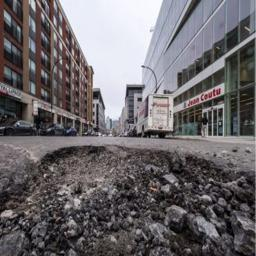

------------------------------
Label: Non-damaged_building


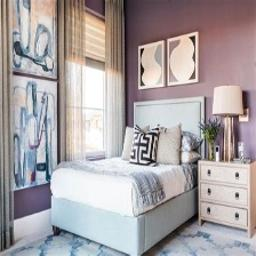

------------------------------
Label: Non-damaged_building


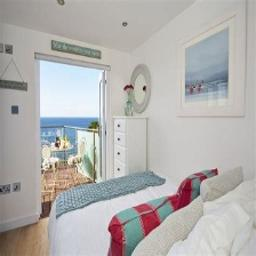

------------------------------
Label: Damaged_highway


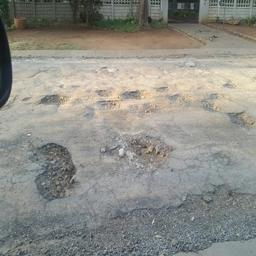

------------------------------
Label: Damaged_highway


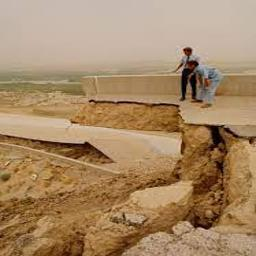

------------------------------


In [18]:
import random
from IPython.display import display, Image

SEED = 42 # Define SEED before use

# Get a few random samples from the dataframe
sample_df = df.sample(5, random_state=SEED)

for index, row in sample_df.iterrows():
    image_path = row['filepath']
    label = row['label']
    print(f"Label: {label}")
    display(Image(filename=image_path))
    print("-" * 30)

In [19]:
import os
import shutil
from sklearn.model_selection import train_test_split
from pathlib import Path

# ==== CONFIGURATION ====
# Path to your original dataset
SOURCE_DIR = Path("dataset_extracted/train")   # Use the extracted train directory

# Create 5-level folders (if they don't exist as destination)
NEW_LABELS = ["very_good", "good", "needs_maintenance", "bad", "very_bad"]

# Mapping: old folders → new condition labels
FOLDER_MAPPING = {
    "Non-damaged_highway": ["very_good", "good"],    # split good roads into 2 categories
    "Damaged_highway": ["needs_maintenance", "bad"], # damaged roads split into 2 levels
    "debris": ["very_bad"],                         # severe condition
}

# Create the new directories if they don't exist already
for label in NEW_LABELS:
    os.makedirs(SOURCE_DIR / label, exist_ok=True)


# ==== MAIN PROCESS ====
for old_folder, new_labels in FOLDER_MAPPING.items():
    src_path = SOURCE_DIR / old_folder

    if not src_path.exists():
        print(f"⚠️ Source folder not found: {src_path}. Skipping.")
        continue

    images = os.listdir(src_path)

    if not images:
        print(f"⚠️ No images found in {old_folder}. Skipping.")
        continue

    print(f"\nProcessing folder: {old_folder}")

    if len(new_labels) == 1:
        # Move all images to the single new label folder
        dest_label = new_labels[0]
        dest_path = SOURCE_DIR / dest_label

        # Only move if the source and destination folders are different
        if src_path != dest_path:
             print(f"Moving {len(images)} images from {old_folder} → {dest_label}")
             for img in tqdm(images):
                 src_file = os.path.join(src_path, img)
                 dest_file = os.path.join(dest_path, img)
                 # Check if the file already exists in the destination before moving (to avoid errors if run multiple times)
                 if not os.path.exists(dest_file):
                    shutil.move(src_file, dest_file)
             # Remove the old folder if it's now empty and not one of the new destination folders
             if not os.listdir(src_path) and old_folder not in NEW_LABELS:
                 os.rmdir(src_path)
                 print(f"Removed empty source folder: {old_folder}")
        else:
            print(f"Source and destination are the same ({old_folder} → {dest_label}). No move needed.")


    else:
        # Split images roughly 50/50 between the two new labels
        dest_label1 = new_labels[0]
        dest_label2 = new_labels[1]
        dest_path1 = SOURCE_DIR / dest_label1
        dest_path2 = SOURCE_DIR / dest_label2

        # Filter out images that might have already been moved if the cell was run partially
        images_to_split = [img for img in images if not (os.path.exists(dest_path1 / img) or os.path.exists(dest_path2 / img))]

        if not images_to_split:
             print(f"No images left to split in {old_folder}.")
             # Remove the old folder if it's now empty and not one of the new destination folders
             if not os.listdir(src_path) and old_folder not in NEW_LABELS:
                 os.rmdir(src_path)
                 print(f"Removed empty source folder: {old_folder}")
             continue


        train_imgs, test_imgs = train_test_split(images_to_split, test_size=0.5, random_state=42)

        print(f"Splitting {old_folder} into {dest_label1} and {dest_label2} ({len(train_imgs)} / {len(test_imgs)})")

        print(f"Moving to {dest_label1}...")
        for img in tqdm(train_imgs):
             src_file = os.path.join(src_path, img)
             dest_file = os.path.join(dest_path1, img)
             shutil.move(src_file, dest_file)

        print(f"Moving to {dest_label2}...")
        for img in tqdm(test_imgs):
             src_file = os.path.join(src_path, img)
             dest_file = os.path.join(dest_path2, img)
             shutil.move(src_file, dest_file)

        # Remove the old folder if it's now empty and not one of the new destination folders
        if not os.listdir(src_path) and old_folder not in NEW_LABELS:
            os.rmdir(src_path)
            print(f"Removed empty source folder: {old_folder}")


print("\n🎯 Dataset reorganized successfully in place!")
print("Next: Update the dataset_dir variable in the code cell that builds the dataframe to point to the modified train directory.")


Processing folder: Non-damaged_highway
Splitting Non-damaged_highway into very_good and good (239 / 239)
Moving to very_good...


100%|██████████| 239/239 [00:00<00:00, 33698.82it/s]


Moving to good...


100%|██████████| 239/239 [00:00<00:00, 22726.40it/s]


Removed empty source folder: Non-damaged_highway

Processing folder: Damaged_highway
Splitting Damaged_highway into needs_maintenance and bad (324 / 324)
Moving to needs_maintenance...


100%|██████████| 324/324 [00:00<00:00, 29652.72it/s]


Moving to bad...


100%|██████████| 324/324 [00:00<00:00, 33151.70it/s]


Removed empty source folder: Damaged_highway

Processing folder: debris
Moving 372 images from debris → very_bad


100%|██████████| 372/372 [00:00<00:00, 32474.73it/s]

Removed empty source folder: debris

🎯 Dataset reorganized successfully in place!
Next: Update the dataset_dir variable in the code cell that builds the dataframe to point to the modified train directory.


In [21]:
import random
from IPython.display import display, Image

# Get a few random samples from the dataframe
sample_df = df.sample(5, random_state=42)

for index, row in sample_df.iterrows():
    image_path = row['filepath']
    label = row['label']
    print(f"Label: {label}")
    display(Image(filename=image_path))
    print("-" * 30)

Label: Damaged_highway


FileNotFoundError: [Errno 2] No such file or directory: '/content/dataset_extracted/train/Damaged_highway/3 (2).jpg'

In [22]:
# 2) Build a dataframe of filepaths + labels (auto-detects subfolders as classes)
# Change this path if your dataset is elsewhere
dataset_dir = Path('dataset_extracted/train')
  # <-- EDIT if needed

# fallback attempts
if not dataset_dir.exists():
    alt = [Path('train'), Path('data/train'), Path('dataset'), Path('.')]
    for a in alt:
        if a.exists() and any(p.is_dir() for p in a.iterdir()):
            dataset_dir = a
            break

print('Using dataset_dir =', dataset_dir)
classes = [p.name for p in dataset_dir.iterdir()
           if p.is_dir() and not p.name.startswith('.')]
classes = sorted(classes)

print('Detected classes:', classes)

rows = []
for cls in classes:
    for img_path in (dataset_dir/cls).glob('*'):
        if img_path.suffix.lower() in ['.jpg','.jpeg','.png','.bmp']:
            rows.append({'filepath': str(img_path.resolve()), 'label': cls})

if len(rows) == 0:
    raise FileNotFoundError(f'No images found under {dataset_dir} — please update dataset_dir path')

df = pd.DataFrame(rows)
print('Total images found:', len(df))
display(df.head())

Using dataset_dir = dataset_extracted/train
Detected classes: ['Non-damaged_building', 'bad', 'damaged_buildings', 'good', 'needs_maintenance', 'very_bad', 'very_good']
Total images found: 3393


,filepath,label
0,/content/dataset_extracted/train/Non-damaged_b...,Non-damaged_building
1,/content/dataset_extracted/train/Non-damaged_b...,Non-damaged_building
2,/content/dataset_extracted/train/Non-damaged_b...,Non-damaged_building
3,/content/dataset_extracted/train/Non-damaged_b...,Non-damaged_building
4,/content/dataset_extracted/train/Non-damaged_b...,Non-damaged_building


In [23]:
# 3) Parameters and helper function to create generators for a given train/val split
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10  # change as needed
NUM_FOLDS = 5
SEED = 42

def make_generators(train_df, val_df, rotation_range=30):
    print("Creating ImageDataGenerators...")

    # Use ImageDataGenerator for augmentation on train, and only rescale for val
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=rotation_range,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    val_datagen = ImageDataGenerator(rescale=1./255)

    print(f"Building training generator with {len(train_df)} images...")
    train_gen = train_datagen.flow_from_dataframe(
        train_df, x_col='filepath', y_col='label',
        target_size=IMG_SIZE, class_mode='categorical',
        batch_size=BATCH_SIZE, shuffle=True, seed=SEED
    )

    print(f"Building validation generator with {len(val_df)} images...")
    val_gen = val_datagen.flow_from_dataframe(
        val_df, x_col='filepath', y_col='label',
        target_size=IMG_SIZE, class_mode='categorical',
        batch_size=BATCH_SIZE, shuffle=False, seed=SEED
    )


    return train_gen, val_gen


In [24]:
# 4) MobileNetV2 model factory (transfer learning)

def build_mobilenetv2(num_classes, img_size=IMG_SIZE, train_base=False, dropout=0.3):
    print("🔧 Building MobileNetV2 model...")
    print(f" - Input image size: {img_size}")
    print(f" - Number of classes: {num_classes}")
    print(f" - Base trainable: {train_base}")
    print(f" - Dropout rate: {dropout}")

    # Load pre-trained MobileNetV2 base model
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=img_size + (3,),
        include_top=False,
        weights='imagenet',
        pooling='avg'
    )
    base_model.trainable = train_base  # whether to fine-tune base

    # Build the model
    inputs = layers.Input(shape=img_size + (3,))
    x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
    x = base_model(x, training=False)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)

    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )



    return model


In [25]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['label'],   # keeps class balance
    random_state=42
)

print("Training samples:", len(train_df))
print("Validation samples:", len(val_df))


Training samples: 2714
Validation samples: 679


In [26]:
train_gen, val_gen = make_generators(train_df, val_df, rotation_range=30)


Creating ImageDataGenerators...
Building training generator with 2714 images...
Found 2714 validated image filenames belonging to 7 classes.
Building validation generator with 679 images...
Found 679 validated image filenames belonging to 7 classes.


In [27]:
model = build_mobilenetv2(
    num_classes=len(df['label'].unique()),
    train_base=True   # fine-tune last layers
)


🔧 Building MobileNetV2 model...
 - Input image size: (224, 224)
 - Number of classes: 7
 - Base trainable: True
 - Dropout rate: 0.3
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [28]:
cb = [
    tf.keras.callbacks.ModelCheckpoint('mobilenetv2_best.h5', save_best_only=True, monitor='val_accuracy'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2),
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
]


In [ ]:
from IPython.display import display, Image

image_path = "/content/Processed_Train/Damaged_highway/3 (103).jpg"
display(Image(filename=image_path))

In [ ]:
EPOCHS = 10  # increase later if GPU available

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=cb,
    verbose=1
)


In [ ]:
val_steps = math.ceil(len(val_df)/BATCH_SIZE)
val_gen.reset()

preds = model.predict(val_gen, steps=val_steps)
y_pred = np.argmax(preds, axis=1)
y_true = val_gen.classes

from sklearn.metrics import accuracy_score, classification_report
acc = accuracy_score(y_true, y_pred)
print(f'Validation Accuracy: {acc:.4f}')
print(classification_report(y_true, y_pred, target_names=list(val_gen.class_indices.keys())))


In [ ]:
# Unfreeze top layers
for layer in model.layers[-40:]:
    layer.trainable = True

# Compile again with a smaller learning rate
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune for 5 epochs
fine_tune_history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    verbose=1
)


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df['label']),
    y=df['label']
)

class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)


In [ ]:
model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=cb,
    class_weight=class_weights,
    verbose=1
)


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)


In [ ]:
train_datagen

In [ ]:
display(train_datagen)

In [ ]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

# Callbacks
cb = [
    ModelCheckpoint('mobilenetv2_best.keras', save_best_only=True, monitor='val_accuracy'),
    EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True),
    lr_scheduler
]


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# ✅ 1) Base Model (MobileNetV2)
def build_mobilenetv2(num_classes, img_size=(224, 224), train_base=False, dropout=0.3):
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=img_size + (3,),
        include_top=False,
        weights='imagenet',
        pooling='avg'
    )
    base_model.trainable = train_base  # initially freeze base layers

    inputs = layers.Input(shape=img_size + (3,))
    x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
    x = base_model(x, training=False)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model




In [ ]:
from IPython.display import display, Image

image_path = "/content/Processed_Train/Damaged_highway/3 (1).jpeg"
display(Image(filename=image_path))

In [ ]:
import math
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

val_steps = math.ceil(len(val_df)/BATCH_SIZE)
val_gen.reset()

preds = model.predict(val_gen, steps=val_steps)
y_pred = np.argmax(preds, axis=1)
y_true = val_gen.classes

acc = accuracy_score(y_true, y_pred)
print(f'Validation Accuracy: {acc:.4f}')
print(classification_report(y_true, y_pred, target_names=list(val_gen.class_indices.keys())))

In [ ]:
from collections import Counter
print(Counter(train_gen.classes))